# Домашнее задание 3. Алгоритмы кластеризации

Основная задача этого задания -- реализация одного из алгоритмов кластеризации. Кроме того, мы научимся подбирать параметры алгоритма, визуализируем результат кластеризации и попытаемся проанализировать природу полученных кластеров.

In [1]:
import pandas as pd
import pylab as pl
import numpy as np
import scipy.spatial as ss
import sklearn.cluster as sc
import sklearn.manifold as sm
import sklearn.datasets as ds
import sklearn.metrics as smt

# Plotting config
%pylab inline

/Users/irinaogneva/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Populating the interactive namespace from numpy and matplotlib


Cчитываем данные, полученные в результате выполнения предыдущего домашнего задания, в `data frame` библиотеки `pandas`. Конвертируем данные в массив `numpy`.

In [2]:
data_df = pd.read_csv("hw2_out.csv", sep="\t", header=0, index_col="uid")
x = data_df.values

Алгоритм кластеризации, который необходимо реализовать, выбирается на основании Вашего логина на портале Техносферы. При проверке домашнего задания бадут осуществляться проверка логина и соответствующего алгоритма.

In [3]:
algorithms = [
    u"Gaussian Mixture Model с использованием maximum a-posteriori для выбора кластера (параметр - k)",
    u"Hierarchical clustering с поддержкой single-linkage, complete-linkage, average-linkage (параметры - k, linkage)",
    u"DBSCAN. (параметры  - epsilon, min_pts)", 
    u"OPTICS. (параметры - epsilon, min_pts)"
]

my_algorithm = algorithms[hash("a.sinyukov") % len(algorithms)]
print u"Реализуем алгоритм кластеризации '%s'" % my_algorithm

Реализуем алгоритм кластеризации 'OPTICS. (параметры - epsilon, min_pts)'


Алгоритм кластеризации должен удовлетворять следующему интерфейсу. Конструктор принимает набор параметров, необходимых для работы алгоритма кластеризации. Метод `fit` подсчитывает параметры модели и возвращает `self`. Метод `predict` возвращает вектор с индексами кластеров для поданных в него объектов `x`

In [4]:
class Clustering:
    """
    Implement clustering algorithm according 
    """
    class Point:
        def __init__(self, index, coord):
            self.index = index;
            self.coord = coord
            self.core_dist = None
            self.reach_dist = None
            self.cluster = None
            self.processed = False
    
    def __init__(self, epsilon, min_pts):
        self.eps = epsilon
        self.min_pts = min_pts
        self.ordered = []
        self.tree = []
        self.points = []
        
        return
    
    def find_neighbours(self, point):
        return [self.points[i] for i in self.tree.query_ball_point(point.coord, self.eps) if point.index != i]
   
    def process(self, point):
        point.processed = True
        self.ordered.append(point)
        
    def calc_core_dist(self, point, neigh):
        if point.core_dist is not None:
            return point.core_dist
        if len(neigh) >= self.min_pts - 1:
            tmpdist1 = self.tree.query(point.coord, self.min_pts)
            point.core_dist = tmpdist1[0][self.min_pts - 1]
            
        return point.core_dist
    
    def distance(self, point1, point2):
        coords = [point1.coord, point2.coord]
        dist = ss.distance.pdist(coords)
        return dist[0]
    
    def update(self, neigh, point, seeds):
        for n in neigh:
            if not n.processed:
                new_reach_dist = max(point.core_dist, self.distance(point, n))
                if n.reach_dist is None:
                    n.reach_dist = new_reach_dist
                    seeds.append(n)
                elif new_reach_dist < n.reach_dist:
                    n.reach_dist = new_reach_dist
    
    def fit(self, x, y=None):
        self.x_len = len(x)
        for i in xrange(self.x_len):
            self.points.append(self.Point(i, x[i]))
        self.tree = ss.KDTree(x)
        
        for point in self.points: 
            if not point.processed:
                point_neigh = self.find_neighbours(point)
                self.process(point)
                if self.calc_core_dist(point, point_neigh) is not None:
                    seeds = []
                    self.update(point_neigh, point, seeds)
                    while(seeds):
                        seeds.sort(key=lambda p: p.reach_dist)
                        n = seeds.pop(0)
                        self.process(n)
                        n_neigh = self.find_neighbours(n)
                        if self.calc_core_dist(n, n_neigh) is not None:
                            self.update(n_neigh, n, seeds)     
        return self
    
    def predict(self, x):
        cluster_id = None
        next_cluster = 1;
        eps1 = self.eps
        for point in self.ordered:
            if point.reach_dist is None:
                point.reach_dist = float('infinity') 
            if point.core_dist is None:
                point.core_dist = float('infinity') 
            if  point.reach_dist > eps1:
                if point.core_dist <= eps1:
                    cluster_id = next_cluster;
                    next_cluster += 1
                    point.cluster = cluster_id;
                else:
                    point.cluster = 0;
            else:
                    point.cluster = cluster_id;
        clusters = []
        for point in self.ordered:
            clusters.insert(point.index, point.cluster)
        return clusters
    
    def fit_predict(self, x, y=None):
        self.fit(x, y)
        return self.predict(x)

Сначала проверим реализованный алгоритм кластеризации на классическом наборе данных [Iris](http://www.wikiwand.com/en/Iris_flower_data_set). Загрузим данные (они включены в библиотеку sklearn) и посмотрим на то, как они выглядят в двух проекциях (для простоты используем 2 класса из 3).

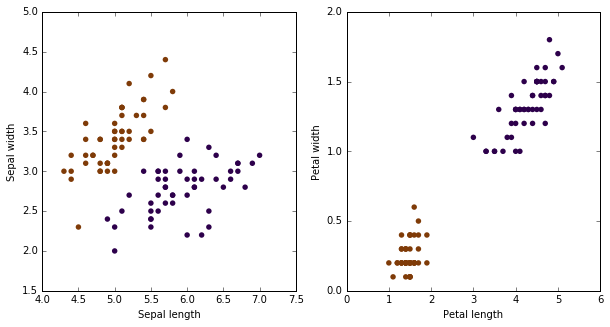

In [5]:
iris = ds.load_iris()
x_iris = iris.data[:100]
y_iris = iris.target[:100]

pl.figure(figsize=(10, 5))

pl.subplot(1, 2, 1)
pl.scatter(x_iris[:, 0], x_iris[:, 1], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

pl.subplot(1, 2, 2)
pl.scatter(x_iris[:, 2], x_iris[:, 3], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Petal length')
plt.ylabel('Petal width')
pl.show()

Видно, что классы разделяются, поэтому можно надеяться, что наш алгоритм "найдет" кластеры, соответствующие исходным классам. Результат работы реализованного алгоритма кластеризации предлагается сравнить с эталонной кластеризацией. Для этого предлагается изучить метрику ([adjusted rand score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html)). В случае если значение этой метрики отличается от 1, предлагается поработать над улучшением реализации своего алгоритма.

In [6]:
pred_iris = Clustering(0.7, 3).fit_predict(x_iris)
print pred_iris
print "Adjusted Rand index for iris is: %.2f" % smt.adjusted_rand_score(y_iris, pred_iris)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Adjusted Rand index for iris is: 1.00


Выбрать и реализовать критерий качества, на основании которого будут подбираться параметры модели. Варианты критериев:
- Инерция (сумма квадратов расстояний от каждой из точек до ближайшего к этой точке центроида)
- Средний диаметр (максимальное расстояние между точками в кластере) или радиус (расстояние от центроида до самой дальней от него точки в кластере)
- Sihouette

**Критерий качества необходимо выбрать таким образом, чтобы он подходил для реализованного алгоритма**

In [8]:
def quality(x, y):
    cls = {} # все кластеры
    for elem in range(len(y)):
        if (cls.get(y[elem],None) is None):
            cls.update({y[elem] : [elem]})
        else:
            cls[y[elem]].append(elem)
    matrix = ss.distance.squareform(ss.distance.pdist(x))            
    k = len(cls)
    a = []
    b = []
    for i in cls:
        for j in cls[i]:
            len_a = 0
            for k in cls[i]:
                len_a = len_a + matrix[j][k]
            if ((len(cls[i]) - 1) is not 0):
                len_a = len_a / (len(cls[i]) - 1)
            else: len_a = 0
            a.append(len_a) 
            len_b = None
            for i2 in cls:
                len_b_i = 0
                if (i != i2):
                    for k in cls[i2]:
                        len_b_i = len_b_i + matrix[j][k]
                    len_b_i = len_b_i / len(cls[i2])
                    if (len_b is None):
                        len_b = len_b_i
                    else:
                        len_b = min(len_b, len_b_i)
            if (len_b is None):
                len_b = 0
            b.append(len_b)
    qua = 0
    for i in range(len(a)):
        qua += (b[i] - a[i]) / max(a[i],b[i])
    qua = qua/len(a)
    
    return qua
print quality(x_iris, pred_iris)

0.736936816068


##### Применим критерий для выбора параметров алгоритма. Предлагается изменить следующий код таким образом, чтобы кластеризация вызывалась с верным набором параметров. На графике можно будет увидеть зависимость критерия от параметров алгоритма. Необходимо выбрать оптимальные значения этих параметров.

0 1
1 2
2 3
3 4
4 5
5 6
6 7
7 8
8 9
9 10
10 11
11 12
12 13
13 14
14 15
15 16
16 17
17 18
18 19
19 20


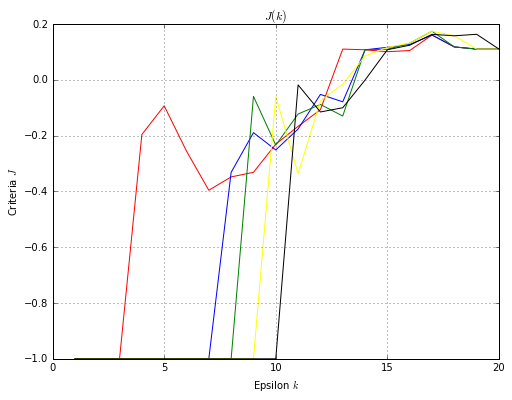

In [9]:
ks = range(1, 21)
criteria3 = np.zeros(len(ks))
criteria5 = np.zeros(len(ks))
criteria7 = np.zeros(len(ks))
criteria9 = np.zeros(len(ks))
criteria11 = np.zeros(len(ks))

for i, k in enumerate(ks):
    print i, k
    cls = Clustering(0.1*k, 3)
    y = cls.fit_predict(x[::50])
    criteria3[i] = quality(x[::50], y)
    cls = Clustering(0.1*k, 7)
    y = cls.fit_predict(x[::50])
    criteria5[i] = quality(x[::50], y)
    cls = Clustering(0.1*k, 11)
    y = cls.fit_predict(x[::50])
    criteria7[i] = quality(x[::50], y)
    cls = Clustering(0.1*k, 15)
    y = cls.fit_predict(x[::50])
    criteria9[i] = quality(x[::50], y)
    cls = Clustering(0.1*k, 19)
    y = cls.fit_predict(x[::50])
    criteria11[i] = quality(x[::50], y)
    
pl.figure(figsize=(8, 6))
pl.plot(ks, criteria3, color = "red")
pl.plot(ks, criteria5, color = "blue")
pl.plot(ks, criteria7, color = "green")
pl.plot(ks, criteria9, color = "yellow")
pl.plot(ks, criteria11, color = "black")
pl.title("$J(k)$")
pl.ylabel("Criteria $J$")
pl.xlabel("Epsilon $k$")
pl.grid()
pl.show()

Далее необходимо кластеризовать данные, используя выбранное количество кластеров, и визуализировать результат с помощью T-SNE. Внимание! На полном объеме данных данный алгоритм может работать существенное время. 

In [34]:
k = 5
cls = Clustering(0.12, 5)
y = cls.fit_predict(x)

Визуализируем результаты кластеризации ([подсказка](http://anokhin.github.io/img/hw3_tsne-kmeans.png)). Можно ли сказать, что в двумерном пространстве объекты из одного кластера находятся недалеко? Какой вывод можно сделать о качестве кластеризации?

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 11434
[t-SNE] Computed conditional probabilities for sample 2000 / 11434
[t-SNE] Computed conditional probabilities for sample 3000 / 11434
[t-SNE] Computed conditional probabilities for sample 4000 / 11434
[t-SNE] Computed conditional probabilities for sample 5000 / 11434
[t-SNE] Computed conditional probabilities for sample 6000 / 11434
[t-SNE] Computed conditional probabilities for sample 7000 / 11434
[t-SNE] Computed conditional probabilities for sample 8000 / 11434
[t-SNE] Computed conditional probabilities for sample 9000 / 11434
[t-SNE] Computed conditional probabilities for sample 10000 / 11434
[t-SNE] Computed conditional probabilities for sample 11000 / 11434
[t-SNE] Computed conditional probabilities for sample 11434 / 11434
[t-SNE] Mean sigma: 0.060918
[t-SNE] Error after 100 iterations with early exaggeration: 1.421260
[t-SNE] Error

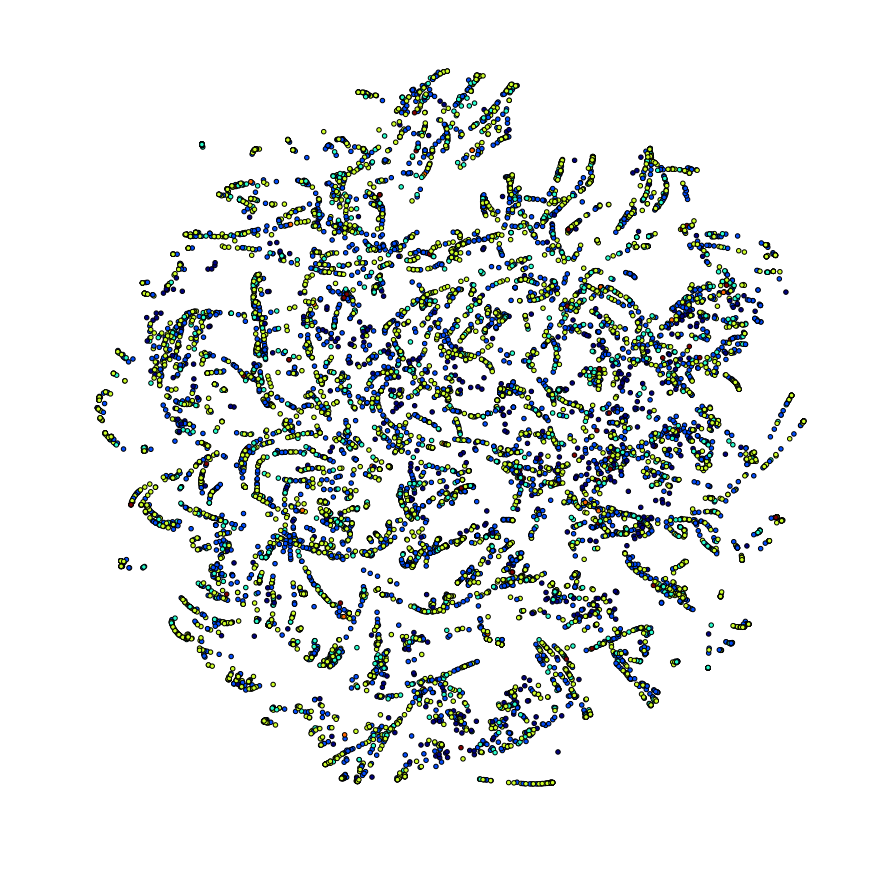

In [35]:
tsne = sm.TSNE(n_components=2, verbose=1, n_iter=1000)
z = tsne.fit_transform(x)

# Color map
cm = pl.get_cmap('jet')
pl.figure(figsize=(15, 15))
pl.scatter(z[:, 0], z[:, 1], c=map(lambda c: cm(1.0 * c / k), y))
pl.axis('off')
pl.show()

Попробуем проанализировать полученные кластеры. Для того, чтобы интерпретировать "суть" каждого из кластеров, построим [radar plot](http://www.wikiwand.com/en/Radar_chart), отображающий их центроиды. Посмотрите на графики и попробуйте объяснить, каким поведением можно охарактеризовать каждый из полученных кластеров? Есть ли среди кластеров похожие?

Реализация радара позаимствована отсюда: 
http://www.science-emergence.com/Matplotlib/MatplotlibGallery/RadarChartMatplotlibRougier/

ValueError: num must be 1 <= num <= 9, not 10

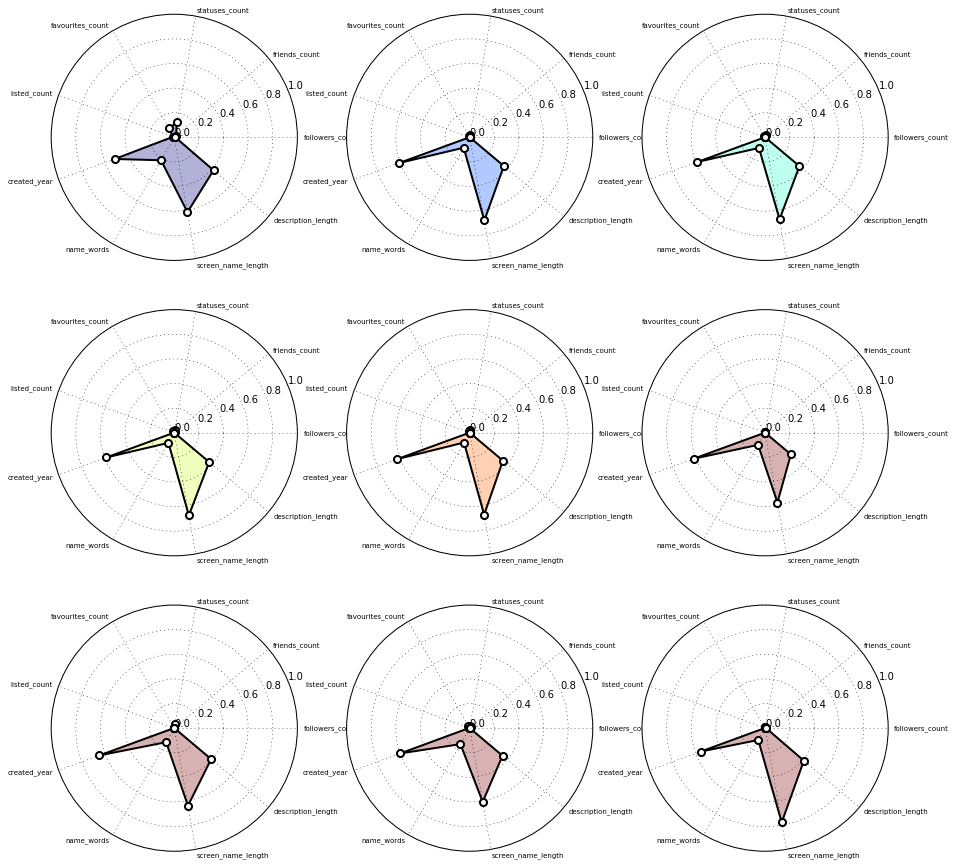

In [37]:
def radar(centroid, features, axes, color):
    # Set ticks to the number of features (in radians)
    t = np.arange(0, 2*np.pi, 2*np.pi/len(features))
    plt.xticks(t, [])

    # Set yticks from 0 to 1
    plt.yticks(np.linspace(0, 1, 6))

    # Draw polygon representing centroid
    points = [(x, y) for x, y in zip(t, centroid)]
    points.append(points[0])
    points = np.array(points)
    codes = [path.Path.MOVETO,] + [path.Path.LINETO,] * (len(centroid) - 1) + [ path.Path.CLOSEPOLY ]
    _path = path.Path(points, codes)
    _patch = patches.PathPatch(_path, fill=True, color=color, linewidth=0, alpha=.3)
    axes.add_patch(_patch)
    _patch = patches.PathPatch(_path, fill=False, linewidth = 2)
    axes.add_patch(_patch)

    # Draw circles at value points
    plt.scatter(points[:,0], points[:,1], linewidth=2, s=50, color='white', edgecolor='black', zorder=10)

    # Set axes limits
    plt.ylim(0, 1)

    # Draw ytick labels to make sure they fit properly
    for i in range(len(features)):
        angle_rad = i/float(len(features))*2*np.pi
        angle_deg = i/float(len(features))*360
        ha = "right"
        if angle_rad < np.pi/2 or angle_rad > 3*np.pi/2: ha = "left"
        plt.text(angle_rad, 1.05, features[i], size=7, horizontalalignment=ha, verticalalignment="center")

# Some additiola imports
import matplotlib
import matplotlib.path as path
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Choose some nice colors
matplotlib.rc('axes', facecolor = 'white')
# Make figure background the same colors as axes 
fig = plt.figure(figsize=(15, 15), facecolor='white')

cm = pl.get_cmap('jet')

clusters = np.unique(y)
for j, cluster in enumerate(clusters):    
    x_c = x[y == cluster]
    centroid = x_c.mean(axis=0)    
    # Use a polar axes
    axes = plt.subplot(3, 3, j + 1, polar=True)
    radar(centroid, data_df.columns.values, axes, cm(1.0 * j / k))

plt.show()

Поздравляем, Вы завершили домашние задания по модулю "Алгоритмы кластеризации". Надеемся, что это было интересно.